####**2.** Попробуйте изменить параметры нейронной сети, генерирующей текст таким образом, чтобы добиться генерации как можно более осмысленного текста. Пришлите лучший текст из получившихся и опишите предпринятые для его получения действия. Можно использовать текст другого произведения

Лекция 1:53

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

Разбор текста - Токенизация

In [8]:
# Создаем объект для токенизапции
tokenizer = Tokenizer(num_words=10000)
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()
#Читаем текст
corpus = data.lower().split("\n")

--2021-08-16 18:44:58--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.97.128, 173.194.218.128, 64.233.170.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-08-16 18:44:58 (111 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [9]:
corpus[:10]

['from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou, contracted to thine own bright eyes,',
 "feed'st thy light'st flame with self-substantial fuel,",
 'making a famine where abundance lies,',
 'thyself thy foe, to thy sweet self too cruel.',
 "thou that art now the world's fresh ornament",
 'and only herald to the gaudy spring,']

Исполним токенизацию и кодирование

In [10]:
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [11]:
token_list

[]

In [12]:
tokenizer.index_word[10]

'thou'

In [13]:
tokenizer.word_index['love']

14

In [14]:
input_sequences[11:15,:]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,   0,   0,   0,  16,  22,   2, 879,  61]],
      dtype=int32)

In [15]:
label.shape

(15462, 3211)

Создаем сеть

In [16]:
callback = EarlyStopping(monitor='val_loss', patience=10) # создаем обратный вызов - calback - тут "Ранний останов"

In [17]:
model = Sequential()
model.add(Embedding(total_words, 256, input_length=max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
# на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 256) координат - он плотный
#model.add(Bidirectional(LSTM(50, return_sequences = True)))

model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 256)           822016    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               197120    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1605)              207045    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,383,047
Trainable params: 6,383,047
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
history = model.fit(predictors, label, epochs=100, validation_split=0.2, callbacks=[callback],verbose=1)

Epoch 1/100
387/387 [==============================] - 40s 96ms/step - loss: 6.9902 - accuracy: 0.0229 - val_loss: 6.7413 - val_accuracy: 0.0223
Epoch 2/100
387/387 [==============================] - 37s 95ms/step - loss: 6.4817 - accuracy: 0.0224 - val_loss: 6.8697 - val_accuracy: 0.0162
Epoch 3/100
387/387 [==============================] - 37s 95ms/step - loss: 6.3809 - accuracy: 0.0245 - val_loss: 7.1284 - val_accuracy: 0.0168
Epoch 4/100
387/387 [==============================] - 37s 95ms/step - loss: 6.2761 - accuracy: 0.0320 - val_loss: 7.1400 - val_accuracy: 0.0239
Epoch 5/100
387/387 [==============================] - 37s 95ms/step - loss: 6.1453 - accuracy: 0.0381 - val_loss: 7.1796 - val_accuracy: 0.0275
Epoch 6/100
387/387 [==============================] - 37s 95ms/step - loss: 6.0199 - accuracy: 0.0411 - val_loss: 7.5068 - val_accuracy: 0.0268
Epoch 7/100
387/387 [==============================] - 36s 94ms/step - loss: 5.9047 - accuracy: 0.0438 - val_loss: 7.7181 - val_ac

Тест

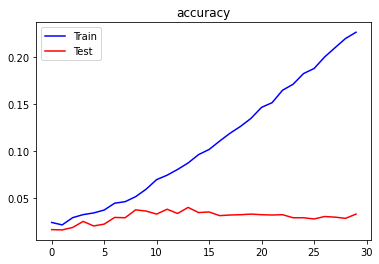

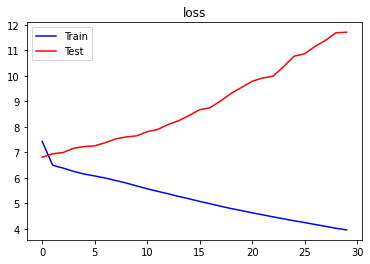

In [33]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.legend()

plt.show()

Строим тест генератора

In [34]:
# начальная строка
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
#seed_text = "She is my girl, I see in"
next_words = 15
# строим последовательность + новое предсказание  
for _ in range(next_words):
  # текущая последовательность (токенизация и дополнение)
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	print(token_list)
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  # делаем предсказание (сразу как индекс класса - у нас 1 из 3211)
	predicted = model.predict_classes(token_list, verbose=0)
  # 
	output_word = ""
	# добавим новое слово в последовательность
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

[591, 18, 5, 352, 393]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[591, 18, 5, 352, 393, 28]
[591, 18, 5, 352, 393, 28, 18]
[591, 18, 5, 352, 393, 28, 18, 152]
[591, 18, 5, 352, 393, 28, 18, 152, 83]
[591, 18, 5, 352, 393, 28, 18, 152, 83, 592]
[591, 18, 5, 352, 393, 28, 18, 152, 83, 592, 145]
[591, 18, 5, 352, 393, 28, 18, 152, 83, 592, 145, 755]
[591, 18, 5, 352, 393, 28, 18, 152, 83, 592, 145, 755, 196]
[591, 18, 5, 352, 393, 28, 18, 152, 83, 592, 145, 755, 196, 443]
[591, 18, 5, 352, 393, 28, 18, 152, 83, 592, 145, 755, 196, 443, 465]
[591, 18, 5, 352, 393, 28, 18, 152, 83, 592, 145, 755, 196, 443, 465, 443]
[591, 18, 5, 352, 393, 28, 18, 152, 83, 592, 145, 755, 196, 443, 465, 443, 465]
[591, 18, 5, 352, 393, 28, 18, 152, 83, 592, 145, 755, 196, 443, 465, 443, 465, 1607]
[591, 18, 5, 352, 393, 28, 18, 152, 83, 592, 145, 755, 196, 443, 465, 443, 465, 1607, 2731]
Help me Obi Wan Kenobi, you're my only hope it me know every report days remain lie rage wherein rage wherein tiger's intents tiger's


То что видим = зацикливание после 3-го добавленного слова (i)

Посмотрим на предсказание через вероятные ответы (не олно слово имеет большую вероятность)

In [35]:
y_p=model.predict(token_list)

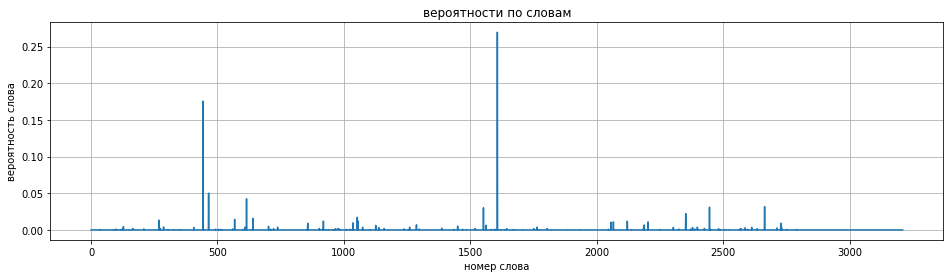

In [36]:
plt.figure(figsize=(16,4))
plt.plot(y_p[0,:])
plt.xlabel('номер слова')
plt.ylabel('вероятность слова')
plt.title('вероятности по словам')
plt.grid('on')
plt.show()

In [23]:
ind_prob=np.where(y_p[0,:]>0.03410)[0]
ind_prob

array([], dtype=int64)

In [24]:
for i,ind in enumerate(ind_prob.tolist()):
  print(tokenizer.index_word[ind], ' : ', y_p[0,ind])

In [25]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
#seed_text = "She is my girl, I see in"
next_words = 15
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  print(token_list)
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  #predicted = model.predict_classes(token_list, verbose=0)
  output_word = ""
  y_p=model.predict(token_list)
  y_predict = y_p * np.random.random(  size = (1,y_p.shape[1]))
  predicted_ind = np.argmax(y_predict,axis = 1)
  for word, index in tokenizer.word_index.items():
    if index == predicted_ind:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

[591, 18, 5, 352, 393]
[591, 18, 5, 352, 393, 3]
[591, 18, 5, 352, 393, 3, 18]
[591, 18, 5, 352, 393, 3, 18, 32]
[591, 18, 5, 352, 393, 3, 18, 32, 196]
[591, 18, 5, 352, 393, 3, 18, 32, 196, 147]
[591, 18, 5, 352, 393, 3, 18, 32, 196, 147, 21]
[591, 18, 5, 352, 393, 3, 18, 32, 196, 147, 21, 128]
[591, 18, 5, 352, 393, 3, 18, 32, 196, 147, 21, 128, 6]
[591, 18, 5, 352, 393, 3, 18, 32, 196, 147, 21, 128, 6, 63]
[591, 18, 5, 352, 393, 3, 18, 32, 196, 147, 21, 128, 6, 63, 33]
[591, 18, 5, 352, 393, 3, 18, 32, 196, 147, 21, 128, 6, 63, 33, 18]
[591, 18, 5, 352, 393, 3, 18, 32, 196, 147, 21, 128, 6, 63, 33, 18, 235]
[591, 18, 5, 352, 393, 3, 18, 32, 196, 147, 21, 128, 6, 63, 33, 18, 235, 18]
[591, 18, 5, 352, 393, 3, 18, 32, 196, 147, 21, 128, 6, 63, 33, 18, 235, 18, 196]
Help me Obi Wan Kenobi, you're my only hope to me doth lie ' be face i now do me seen me lie lie


Help me Obi Wan Kenobi, you're my only hope to thee doth lie night ' night be time affords night doth sight doth gone
Зацикливание на слове ночь

####**Ответ** Попробую добавить слой в модель

In [ ]:
# model.add(Dense(total_words/4, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

Первый вариант с ранним остановом остановился на val_accuracy: 0.0239, пробую отключить и обучать на 20ти эпохах 

Увеличение val_accuracy примерно 1 тысячная на эпоху, заменю активационную добавленного слоя на tanh и попробую 30 эпох

In [ ]:
# model.add(Dense(total_words/4, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))

Самый высокий val_accuracy: 0.0375 был на 9ой эпохе, изменение кол-во эпох активационной функции и добавление слоя не дает особого добавление val_accuracy

Возвращаю параметры и callback, пробую LSTM(64) - val_accuracy: 0.0352 на 9ой эпохе


LSTM(32) - val_accuracy: 0.0372 на 11  эпохе



LSTM(16) val_accuracy: 0.0262

ПРобую функцию активации tanh - val_accuracy: 0.0307 на 8ой эпохе

In [49]:
model = Sequential()
model.add(Embedding(total_words, 256, input_length=max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
# на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 256) координат - он плотный
#model.add(Bidirectional(LSTM(50, return_sequences = True)))

model.add(LSTM(10))
model.add(Dropout(0.2))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 10, 256)           822016    
_________________________________________________________________
lstm_12 (LSTM)               (None, 10)                10680     
_________________________________________________________________
dropout_12 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1605)              17655     
_________________________________________________________________
dense_29 (Dense)             (None, 3211)              5156866   
Total params: 6,007,217
Trainable params: 6,007,217
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
history = model.fit(predictors, label, epochs=30, validation_split=0.2, verbose=1, callbacks=[callback])

Epoch 1/30
387/387 [==============================] - 28s 68ms/step - loss: 6.9623 - accuracy: 0.0231 - val_loss: 6.8632 - val_accuracy: 0.0165
Epoch 2/30
387/387 [==============================] - 26s 66ms/step - loss: 6.5317 - accuracy: 0.0260 - val_loss: 6.9618 - val_accuracy: 0.0200
Epoch 3/30
387/387 [==============================] - 26s 66ms/step - loss: 6.4544 - accuracy: 0.0246 - val_loss: 7.0861 - val_accuracy: 0.0184
Epoch 4/30
387/387 [==============================] - 25s 66ms/step - loss: 6.3821 - accuracy: 0.0269 - val_loss: 7.0893 - val_accuracy: 0.0191
Epoch 5/30
387/387 [==============================] - 26s 66ms/step - loss: 6.2994 - accuracy: 0.0297 - val_loss: 7.1318 - val_accuracy: 0.0249
Epoch 6/30
387/387 [==============================] - 26s 66ms/step - loss: 6.2385 - accuracy: 0.0311 - val_loss: 7.2128 - val_accuracy: 0.0223
Epoch 7/30
387/387 [==============================] - 26s 66ms/step - loss: 6.1988 - accuracy: 0.0362 - val_loss: 7.3027 - val_accuracy:

####D В итоге максимум что получилось добиться это LSTM(32) - val_accuracy: 0.0372 на 11  эпохе